
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Change-Perturbed Change Set Activation Gradients

In [1]:
#@title Import libraries
import transformer_lens, torch, gc, itertools, functools, math
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, gradient, localizing, patching

## Model

In [47]:
model_type = "gpt-neo-125M"
model = modelHandlers.load_model(model_type=model_type, DEVICE="cpu")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']
setting no_grad on ['embed', 'pos_embed', 'unembed']


## Load Data

In [48]:
## mem and non-mem set
#(mem_prompts, mem_counts),(non_mem_prompts,non_mem_counts) = dataLoaders.load_pile_splits("acc/gpt2-medium", as_torch=True)
#train_dl, test_dl = dataLoaders.train_test_batching(mem_prompts, non_mem_prompts, mem_batch=10, non_mem_batch=10, test_frac=0.0, shuffle=True, set_twice="k")
#c_toks_NI, k_toks_NI = next(iter(train_dl))
#c_toks_NI, k_toks_NI = c_toks_NI.squeeze(0), k_toks_NI.squeeze(0)

In [49]:
## load perturbed mem set and original mem set
mem_prompts, non_mem_prompts = dataLoaders.load_perturbed_mem(file_path=f"acc/{model_type}")
train_dl = torch.utils.data.DataLoader(list(zip(mem_prompts, non_mem_prompts)), batch_size=1, shuffle=False)
c_toks_NI, k_toks_NI = next(iter(train_dl))

### Identify Intervention Token and Impact Token

In [50]:
def get_interv_impact_indeces(c_toks_NI:torch.tensor, k_toks_NI:torch.tensor):
    """
    function to get the positions of the intervention (src) and impact (trg) token
    """
    ck_diff_mask = torch.where(c_toks_NI != k_toks_NI, 1,0)
    ck_diff_cumsum = torch.cumsum(ck_diff_mask, dim=-1) ## intervention

    ## find intervention
    src_NI = (ck_diff_cumsum==1).nonzero() 
    src_idcs = torch.cat((torch.zeros(1),(src_NI[:-1,0] != src_NI[1:,0]).nonzero(as_tuple=True)[0] + 1)).long()
    #src_NI = torch.sub(src_NI, torch.cat((torch.zeros(src_NI.shape[0],1),torch.ones(src_NI.shape[0],1)), dim=-1), alpha=1) ## -1 because we care about what token is predicted
    src_NI = src_NI[src_idcs].long() 

    ## find impact
    trg_NI = (ck_diff_cumsum==2).nonzero() 
    trg_NI_idcs = torch.cat((torch.zeros(1),(trg_NI[:-1,0] != trg_NI[1:,0]).nonzero(as_tuple=True)[0] + 1)).long()
    trg_NI = torch.sub(trg_NI, torch.cat((torch.zeros(trg_NI.shape[0],1),torch.ones(trg_NI.shape[0],1)), dim=-1), alpha=1) ## -1 because we care about what token is predicted
    trg_NI = trg_NI[trg_NI_idcs].long() 
    
    return src_NI, trg_NI

src_NI, trg_NI = get_interv_impact_indeces(c_toks_NI, k_toks_NI)

## Run backprop and collect activations step

In [51]:
def single_seq_metric(nll_NI:torch.tensor, NI_idcs:torch.tensor=None, pool:dict={"c": []}):
    """
    minimizing / preserve keep_score while maximizing change_score
    """
    ## (1) preprocess________________________________________
    ## select tokens to apply metric to
    nll_NI = nll_NI[NI_idcs[:,0], NI_idcs[:,1]]
    #nll_NI = nll_NI[...,I_range[0]:I_range[1]]
        
    ## (2) pooling_______________________________________________
    ## pool over dims but then expand again to retain shapes
    nll_NI = gradient.pool_tensor(nll_NI, pool["c"])             
    print(f"pooling nll_NI {nll_NI.shape}, pool: {pool}")
    
    ## (3) apply metric_______________________________________________
    metric_res = nll_NI.mean()
    print(f"contrast loss: {metric_res}")
    return metric_res, None

metric = functools.partial(single_seq_metric, NI_idcs=trg_NI)
c_fwd_cache, c_bwd_cache, _ = gradient.run_fwd_bwd(model, metric_fn=metric, c_toks_NI=c_toks_NI)
k_fwd_cache, k_bwd_cache, _ = gradient.run_fwd_bwd(model, metric_fn=metric, c_toks_NI=k_toks_NI)

pooling nll_NI torch.Size([1]), pool: {'c': []}
contrast loss: 0.08509835600852966
pooling nll_NI torch.Size([1]), pool: {'c': []}
contrast loss: 0.17640025913715363


In [52]:
POOL_FN = {"l1": lambda x, dim: torch.norm(x, p=1, dim=dim),
         "l2": lambda x, dim: torch.norm(x, p=2, dim=dim),
         "frob": lambda x, dim: torch.linalg.matrix_norm(x, ord='fro'), ## toDo: issue requires 2D input
         "mean_abs": lambda x, dim: torch.mean(torch.abs(x), dim=dim),
         "mean": lambda x, dim: torch.mean(x, dim=dim),
         "max_abs": lambda x, dim: torch.max(torch.abs(x), dim=dim)[0],
         "max": lambda x, dim: torch.max(x, dim=dim)[0],
         "pass": lambda x, dim: (x)}

DIST_FN = {"cos": lambda x1, x2: torch.nn.functional.cosine_similarity(x1, x2, dim=-1),
           "sub": lambda x1, x2: x1-x2,
           "sub_abs": lambda x1, x2: torch.abs(x1-x2)}

def pool_tensor(tensor:torch.tensor, pool:str="max", abs_vals:bool=True, topP:float=1.0, norm_by_entries:bool=False):
    """
    pool a tensor and normalize it by the number of entries
    """
    n_params = tensor.numel()
    if len(tensor.shape) == 5: ##ATTN
        n_params = n_params / 12 ## devide by number of heads    

    if abs_vals: ## take absolute values
        tensor = torch.abs(tensor)
        
    norm_by = 1.0
    if norm_by_entries:
        norm_by = math.log(n_params)#n_params**(1/2)
        tensor[tensor!=0] = tensor[tensor!=0]*(1/norm_by)
    
    if 0.0 < topP < 1.0:
        topP = max(int(topP*tensor.shape[-1]), 1) 
    topK_vals, topK_idcs = torch.topk(tensor, int(topP), dim=-1, largest=True)  
    tensorpool = POOL_FN[pool](topK_vals, dim=-1) ## do pooling
    
    #print(f"abs_vals {abs_vals}, topP {topP} selected, {pool} pooled and normalized by: {norm_by}")
    return tensorpool

In [53]:
def collect_pool(cache:dict, second_cache:dict=None, c_type:str=None, idcs_NI=None):
    vals, names = localizing.collect_c_type(model=model, cache=cache, c_type=c_type)
    if second_cache is not None: ## take the difference before pooling
        vals2, names2 = localizing.collect_c_type(model=model, cache=second_cache, c_type=c_type)
        vals, vals2 = (vals2.sum()/vals.sum())*vals, vals2 ## normalizing
        vals = (vals - vals2)
    pool_vals = pool_tensor(vals, pool="max", abs_vals=True, topP=0.01, norm_by_entries=False)
    
    ## consider either all tokens or only selected token, then mean over sequences
    if idcs_NI is not None: 
        pool_vals = pool_vals[idcs_NI[:,0],idcs_NI[:,1]].mean(0)
    else:
        pool_vals = pool_vals.mean(1).mean(0)
        
    ## reshape for plotting
    names = list()
    if len(pool_vals.shape) == 2: ## attention
        names = [f"{c_type} H{i}" for i in range(0,pool_vals.shape[1])]
    else: ## mlp
        pool_vals = pool_vals.unsqueeze(-1)
        names = [f"{c_type}"]
    return pool_vals, names

## Activation Gradient Pooling and Plotting

In [71]:
fwd_bwd = "bwd"
tok_pos = "trg"

idcs_NI = {"src":src_NI,"trg":trg_NI}[tok_pos]

In [75]:
def gather_activation_grads(cache:dict, second_cache:dict=None,idcs_NI:torch.tensor=None,c_types:list=["q", "k", "v", "z", "pre", "post"]):  #"q", "k", "v", "z", "pre", "post", "attn_out", "mlp_out",  "z", "mlp_in", "post","mlp_out"
    vals, names = [], []
    for c_type in c_types:
        c_type_vals, c_type_names = collect_pool(cache, second_cache, c_type=c_type, idcs_NI=idcs_NI)
        vals.append(c_type_vals)
        names += c_type_names
    vals = torch.cat(vals, dim=-1)
    return vals, names

c_vals, names = gather_activation_grads({"fwd":c_fwd_cache,"bwd":c_bwd_cache}[fwd_bwd], idcs_NI=idcs_NI)
k_vals, names = gather_activation_grads({"fwd":k_fwd_cache,"bwd":k_bwd_cache}[fwd_bwd], idcs_NI=idcs_NI)
diff_vals, names = gather_activation_grads({"fwd":c_fwd_cache,"bwd":c_bwd_cache}[fwd_bwd], {"fwd":k_fwd_cache,"bwd":k_bwd_cache}[fwd_bwd], idcs_NI=idcs_NI)

returning ['blocks.0.attn.hook_q', 'blocks.1.attn.hook_q']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.attn.hook_k', 'blocks.1.attn.hook_k']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.attn.hook_v', 'blocks.1.attn.hook_v']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.attn.hook_z', 'blocks.1.attn.hook_z']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.mlp.hook_pre', 'blocks.1.mlp.hook_pre']... of shape: torch.Size([1, 100, 12, 3072])
returning ['blocks.0.mlp.hook_post', 'blocks.1.mlp.hook_post']... of shape: torch.Size([1, 100, 12, 3072])
returning ['blocks.0.attn.hook_q', 'blocks.1.attn.hook_q']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.attn.hook_k', 'blocks.1.attn.hook_k']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.attn.hook_v', 'blocks.1.attn.hook_v']... of shape: torch.Size([1, 100, 12, 12, 64])
returning ['blocks.0.attn.hook_z', 'blocks.1.attn.hoo

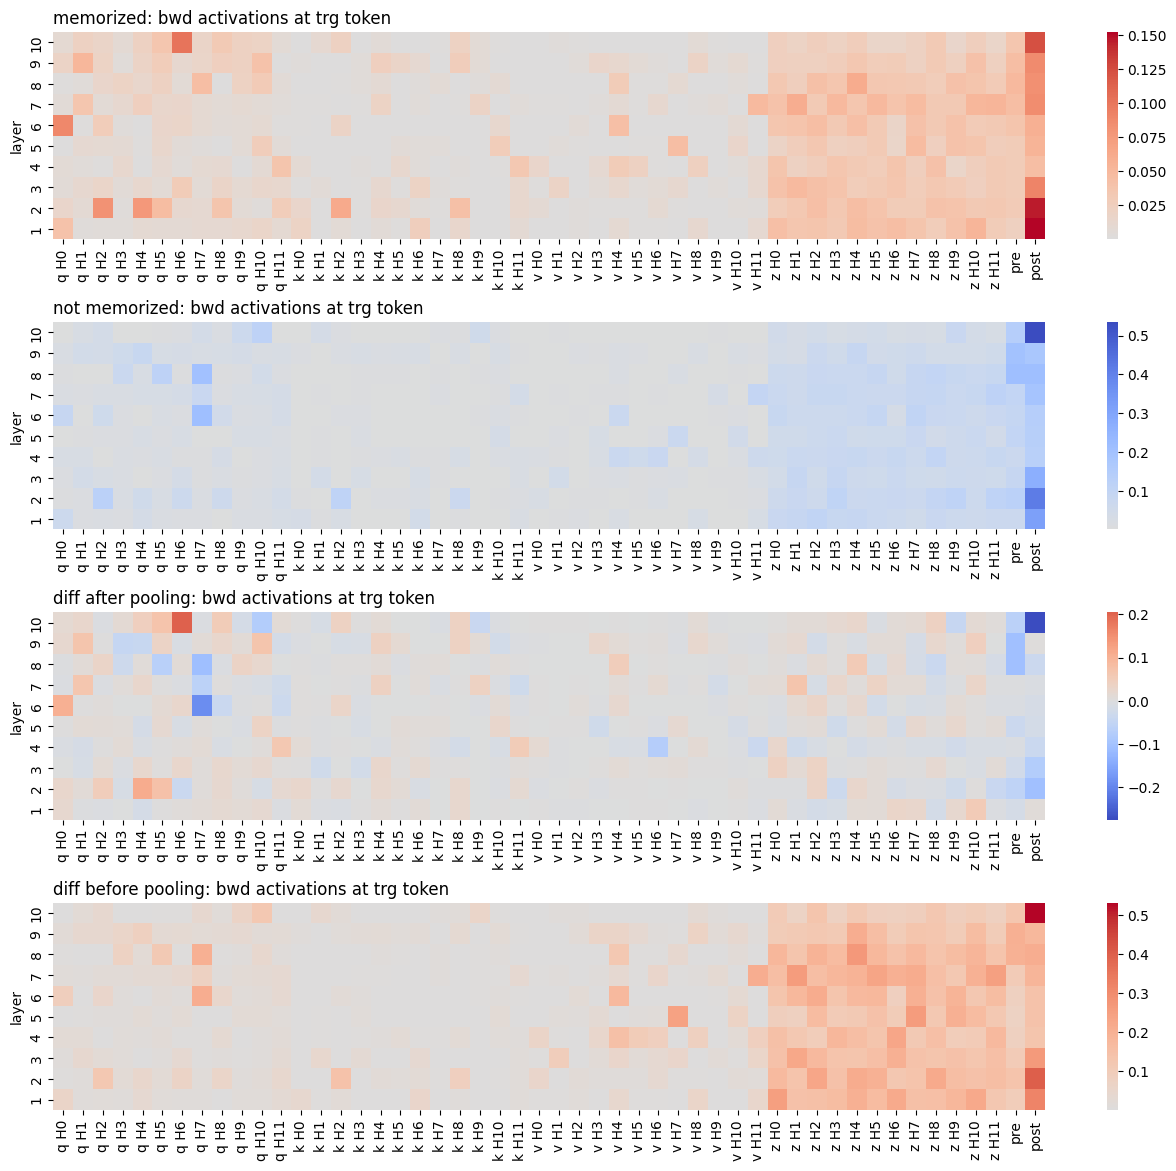

In [74]:
fontsize = 12
fig, axs = plt.subplots(4, 1, figsize=(16, 14), gridspec_kw={'hspace': 0.4})

plot_types = ["memorized", "not memorized", "diff after pooling", "diff before pooling"]
#plot_types = ["keep set 1", "keep set 2", "diff after pooling", "diff before pooling"]

cmaps = ["coolwarm", "coolwarm_r", "coolwarm", "coolwarm"]
vals = [c_vals, k_vals, ((k_vals.sum()/c_vals.sum())*c_vals)-k_vals, diff_vals] 

for i, ax in enumerate(axs):
    plot_vals = vals[i].numpy() 
    sns.heatmap(plot_vals[1:-1,:],cmap=mpl.colormaps[cmaps[i]],center=0.0,xticklabels=names,yticklabels=np.arange(1,plot_vals.shape[0]-1),square=False,ax=ax)# norm=SymLogNorm(linthresh=1.0))
    ax.invert_yaxis()
    ax.set_title(f"{plot_types[i]}: {fwd_bwd} activations at {tok_pos} token", fontsize=fontsize, loc="left")
    ax.set_ylabel("layer")
    
    
#fig.savefig("bwd target.png", dpi=200, bbox_inches="tight")

In [70]:
#pre = c_fwd_cache[transformer_lens.utils.get_act_name("pre", 0)]
#k = c_fwd_cache[transformer_lens.utils.get_act_name("k", 7)]